<a href="https://colab.research.google.com/github/pedrosena138/pmfsl-bert-text-classification/blob/main/BERT_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import TFAutoModelForSequenceClassification, BertTokenizer, pipeline

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12,10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)

Num GPUs Available:  1


In [ ]:
dataset = pd.read_csv('drive/MyDrive/TCC/data/dataset.csv', sep=',')
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1390 entries, 0 to 1389
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1390 non-null   object
 1   label   1390 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 21.8+ KB


,text,label
0,Eu e Cristiano idealizamos uma história para ...,1
1,"Particularmente eu não conhecia o Scratch, mas...",1
2,1 se possível.,1
3,No inicio do projeto tivemos várias dificuldad...,1
4,"\t Bom, inicialmente focamos no cenário e per...",1


In [ ]:
neg, pos = np.bincount(dataset['label'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1390
    Positive: 1233 (88.71% of total)



In [ ]:
def get_tf_dataset(dataset, tokenizer):
    texts_list = dataset['text'].values.tolist()
    labels_list = dataset['label'].values.tolist()
    
    encodings = tokenizer(texts_list, truncation=True, padding='longest')

    tf_dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels_list
    ))

    return tf_dataset

def get_model(model_name, num_labels=2):
    id2label = {0: "Negative", 1: "Positive"}
    label2id = {val: key for key, val in id2label.items()}

    optimizer = keras.optimizers.Adam(learning_rate=1e-6)
    # metricas: precisao e recall (precisao + recall = f_mesure)

    # metrics = [
    #     keras.metrics.Precision(name='precision'),
    #     keras.metrics.Recall(name='recall'),
    # ]

    from_pt = False if model_name == "bert-base-multilingual-cased" else True

    model = TFAutoModelForSequenceClassification.from_pretrained(model_name,
                                                             num_labels=2,
                                                             id2label=id2label, 
                                                             label2id=label2id,
                                                             from_pt=from_pt)
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics='accuracy')
    
    return model

In [ ]:
models = {
    "BERTimbau-base": "neuralmind/bert-base-portuguese-cased",
    "BERTimbau-large": "neuralmind/bert-large-portuguese-cased",
    "mBERT": "bert-base-multilingual-cased"
}

train_dataset, test_dataset = train_test_split(dataset, test_size=.1, shuffle=True)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=.2, shuffle=True)

tokenizer = BertTokenizer.from_pretrained(models["BERTimbau-large"], model_max_length=train_dataset.shape[0])

tf_train_dataset = get_tf_dataset(train_dataset, tokenizer)
tf_val_dataset = get_tf_dataset(val_dataset, tokenizer)
tf_test_dataset = get_tf_dataset(test_dataset, tokenizer)

model = get_model(models["BERTimbau-large"])
model.summary()

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  334396416 
                                                                 
 dropout_225 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2050      
                                                                 
Total params: 334,398,466
Trainable params: 334,398,466
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(tf_train_dataset.batch(20),
                    epochs=3,
                    batch_size=2048,
                    validation_data=tf_val_dataset.batch(20))

Epoch 1/3


ResourceExhaustedError: ignored

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss', fontsize=16)
  plt.legend()

def plot_metrics(history, metrics):
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend();

def plot_confusion_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  1.1891875267028809
accuracy :  0.6690647602081299



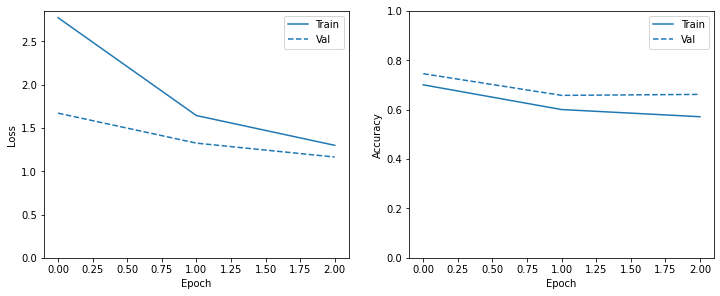

In [ ]:
results = model.evaluate(tf_test_dataset.batch(20), batch_size=2048, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

plot_metrics(history, metrics=model.metrics_names)

Legitimate Transactions Detected (True Negatives):  4
Legitimate Transactions Incorrectly Detected (False Positives):  8
Fraudulent Transactions Missed (False Negatives):  38
Fraudulent Transactions Detected (True Positives):  89
Total Fraudulent Transactions:  127


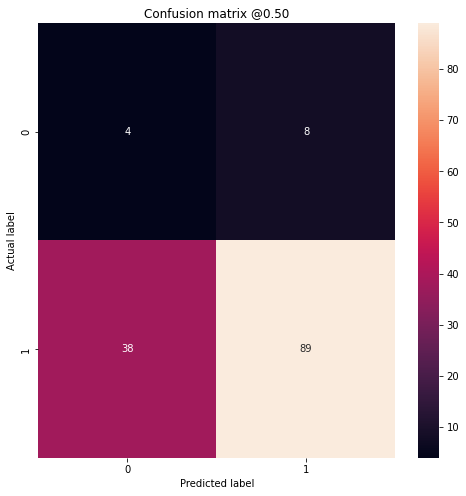

In [ ]:
test_sentences = test_dataset['text'].values.tolist()
encodings = tokenizer(test_sentences, truncation=True, padding='longest', return_tensors="np")
outputs = model(encodings).logits

y = test_dataset['label'].values.tolist()
y_hat = np.argmax(outputs, axis=1)

plot_confusion_matrix(y, y_hat)